In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# ! pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

In [2]:
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]

In [3]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [4]:
weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid.loc[weeklyCovid["new_case"] != 0, "case_change"] = weeklyCovid["case_change"]/weeklyCovid["new_case"]
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid.loc[weeklyCovid["new_death"] != 0, "death_change"] = weeklyCovid["death_change"]/weeklyCovid["new_death"]

In [5]:
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']

In [6]:
tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks

In [7]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    weeklyPrice["stock_price_change"] = weeklyPrice["Adj Close"].diff().fillna(0)
    weeklyPrice["stock_price_change"] = weeklyPrice["stock_price_change"]/weeklyPrice["Adj Close"]
    
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock", "stock_price_change"]],
                          ignore_index = True)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [8]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthCare"

In [9]:

sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)

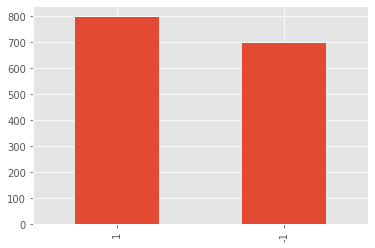

In [10]:
#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")

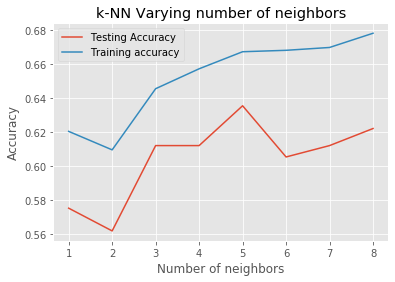

The accuracy score for KNN is: 0.6354515050167224


In [11]:
## KNN 
 
X_knn = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Category','Rise/Fall'],axis=1).values
y_knn = sc_df['Rise/Fall'].values



#Splitting into test and train
X_train_knn,X_test_knn,y_train_knn,y_test_knn = tts(X_knn,y_knn,test_size=0.2,random_state=42, stratify=y_knn)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    
    train_accuracy[i] = knn.score(X_train_knn, y_train_knn)
    test_accuracy[i] = knn.score(X_test_knn, y_test_knn)
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Fitting the model with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
    
train_accuracy = knn.score(X_train_knn, y_train_knn)
test_accuracy = knn.score(X_test_knn, y_test_knn) 

#Accuracy:
print("The accuracy score for KNN is:",test_accuracy)

In [12]:
#Confusion Matrix
y_pred_knn = knn.predict(X_test_knn)
pd.crosstab(y_test_knn, y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,86,53,139
1,56,104,160
All,142,157,299


In [13]:
# Calculating Measures by hand
TP = 104
FP = 53
FN = 56
TN = 86
recall = TP/(TP+FN)
precision= TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.65 
Precision:  0.6624203821656051 
F Measure:  0.6561514195583596


In [14]:
print(classification_report(y_test_knn,y_pred_knn))

              precision    recall  f1-score   support

          -1       0.61      0.62      0.61       139
           1       0.66      0.65      0.66       160

    accuracy                           0.64       299
   macro avg       0.63      0.63      0.63       299
weighted avg       0.64      0.64      0.64       299



In [15]:
## Random Forest Classifier

rfc = RandomForestClassifier()

features=["tot_cases", "case_change", "tot_death", "death_change"]

X_rfc = sc_df.loc[:, features]
Y_rfc = sc_df["Rise/Fall"]
X_train_rfc, X_test_rfc, Y_train_rfc, Y_test_rfc = tts(X_rfc, Y_rfc, test_size=0.2, random_state=42)

rfc.fit(X_train_rfc, Y_train_rfc)
Y_pred_rfc = rfc.predict(X_test_rfc)

In [16]:
accuracy = metrics.accuracy_score(Y_test_rfc, Y_pred_rfc)
print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6688963210702341


In [17]:
pd.crosstab(Y_test_rfc, Y_pred_rfc, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,79,64,143
1,35,121,156
All,114,185,299


In [18]:
TP = 121
FP = 64
FN = 35
TN = 79
recall = TP/(TP+FN)
precision = TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.7756410256410257 
Precision:  0.654054054054054 
F Measure:  0.7096774193548387


In [19]:
print(classification_report(Y_test_rfc,Y_pred_rfc))

              precision    recall  f1-score   support

          -1       0.69      0.55      0.61       143
           1       0.65      0.78      0.71       156

    accuracy                           0.67       299
   macro avg       0.67      0.66      0.66       299
weighted avg       0.67      0.67      0.66       299



In [22]:
## Decision Tree without validation
clf = tree.DecisionTreeClassifier(random_state=0)
features = ["tot_cases","new_case", "tot_death", "new_death"]
X_tree = sc_df.loc[:,features]
Y_tree = sc_df["Rise/Fall"]
X_train_tree, X_test_tree, Y_train_tree, Y_test_tree = tts(X_tree, Y_tree, test_size=0.2, random_state=42)
clf = clf.fit(X_train_tree,Y_train_tree)

In [23]:
#get sorted labels for plot 
import numpy as np
sorted = Y_tree.unique()
sorted = np.sort(sorted)
sorted = list(map(str, sorted))
sorted

['-1', '1']

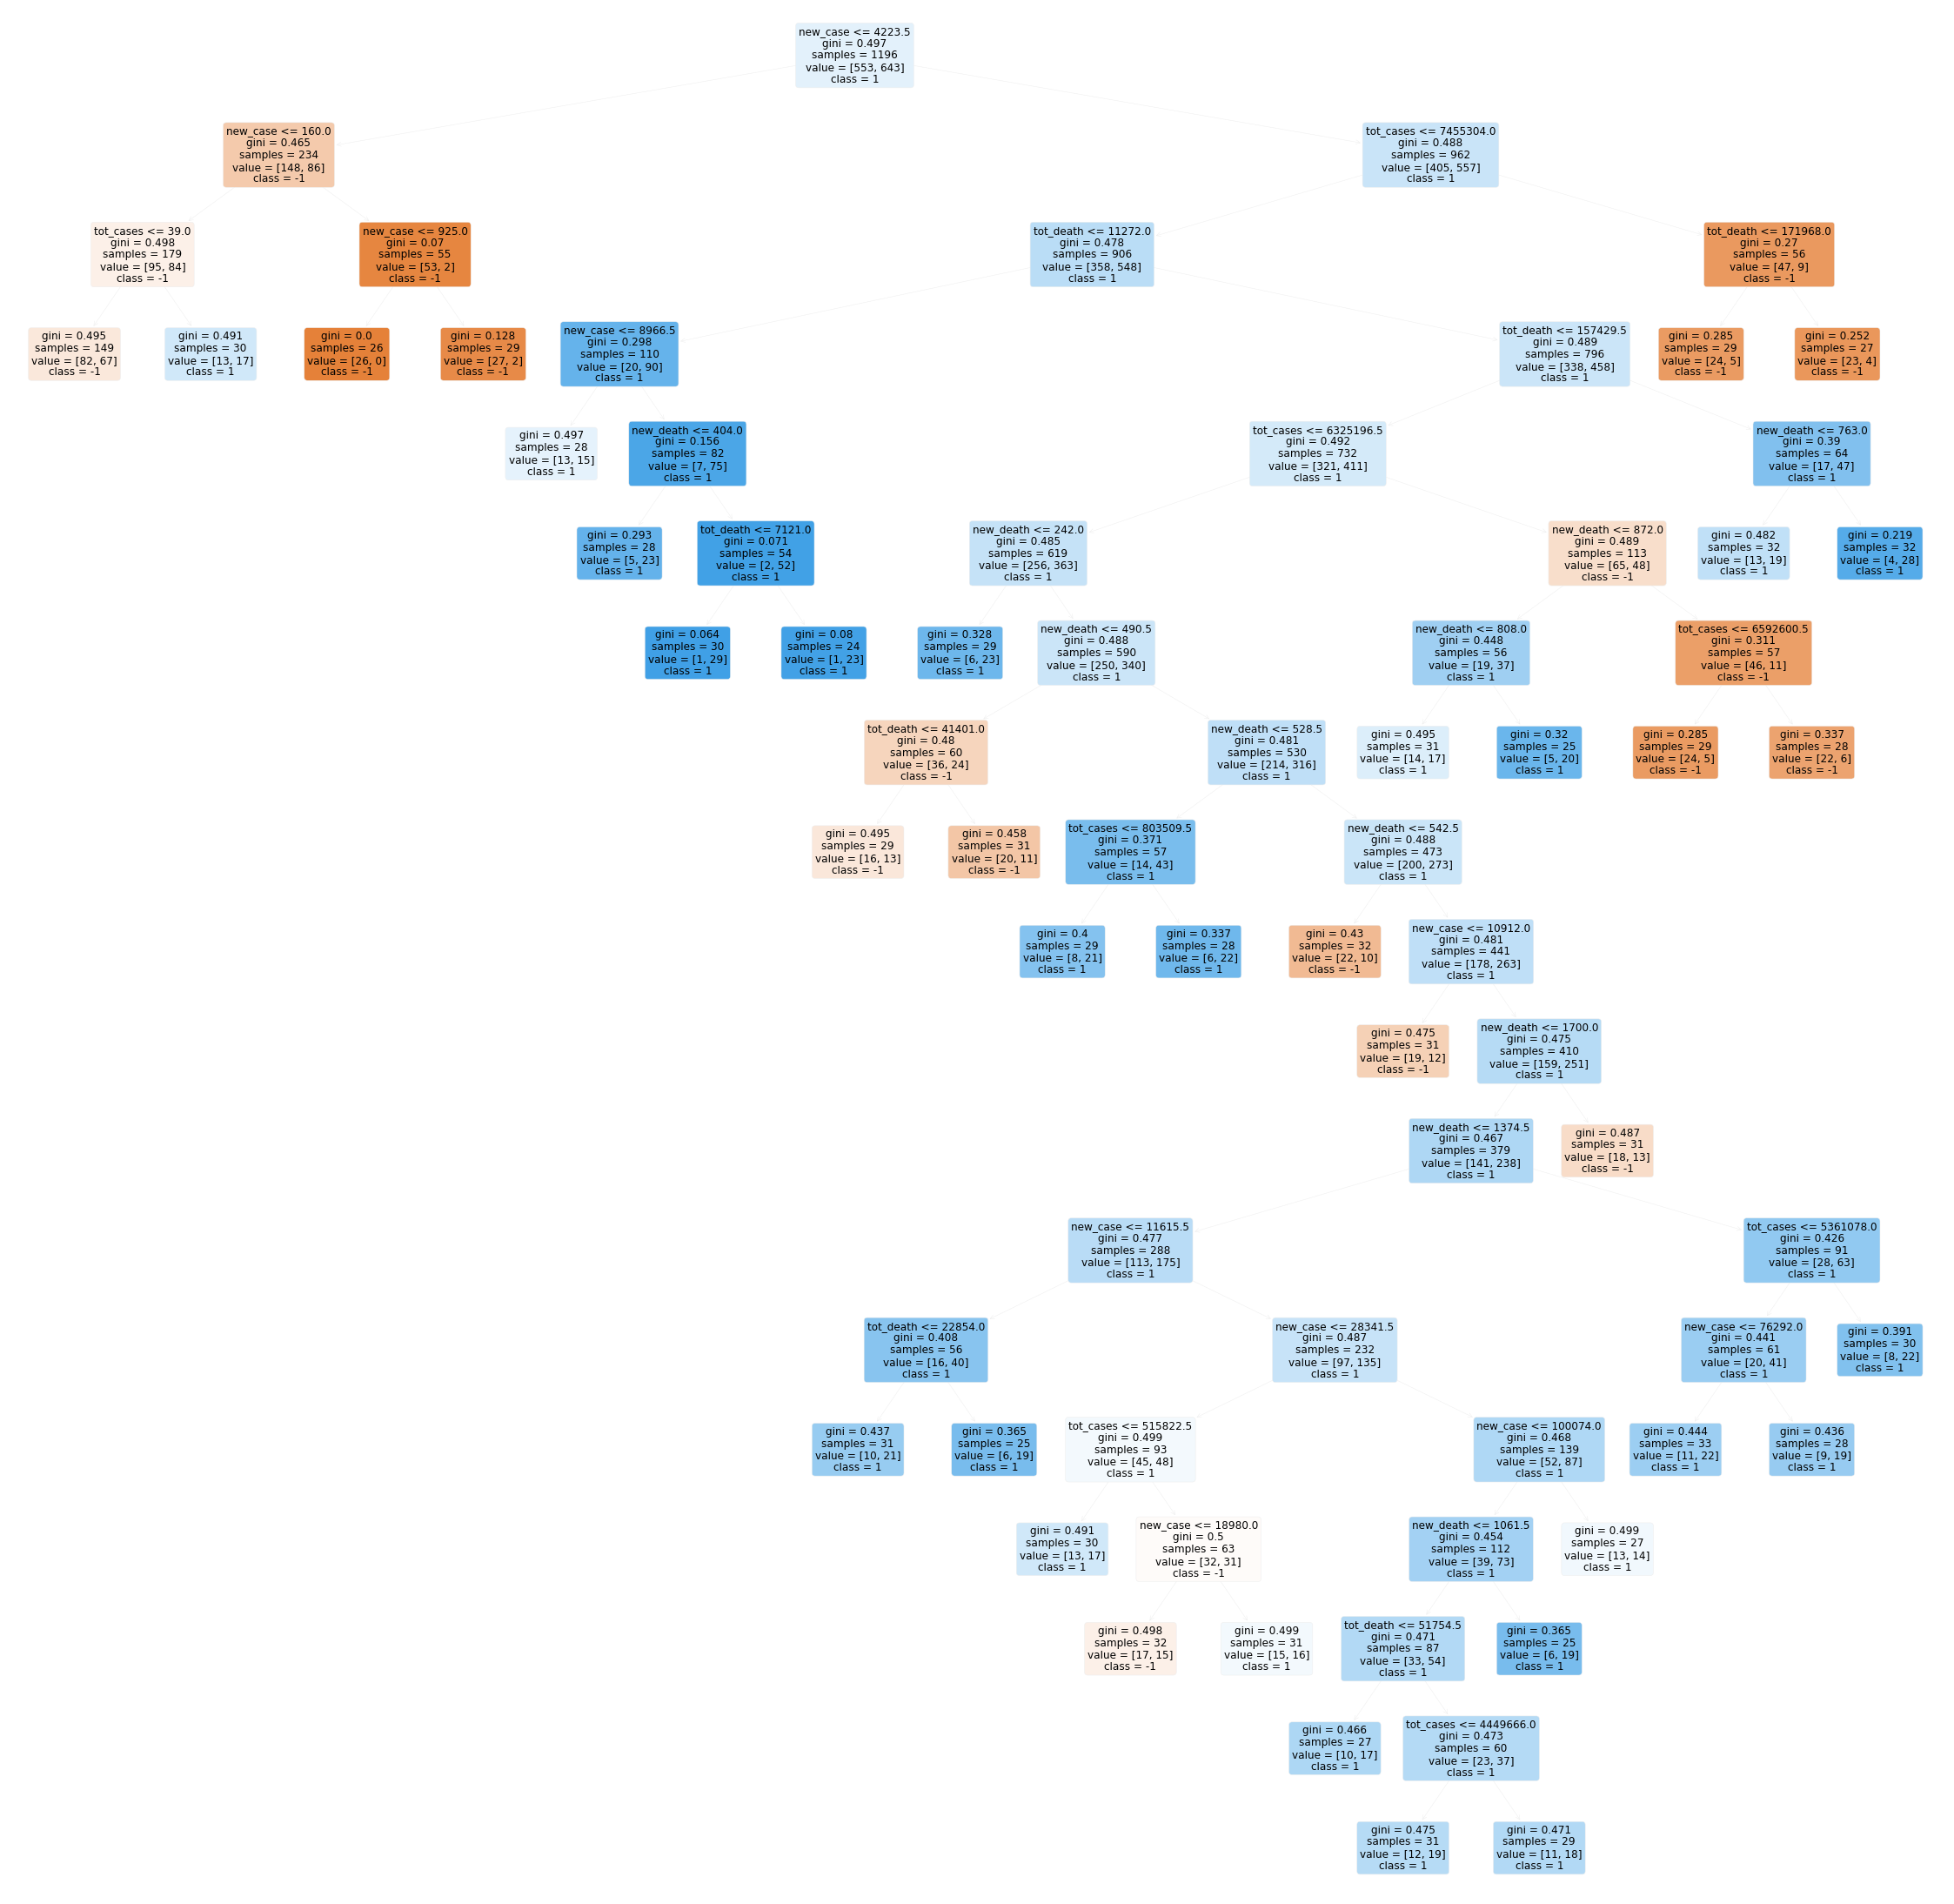

In [24]:
plt.subplots(figsize=(40, 40))
x = tree.plot_tree(clf,rounded=True,filled=True,class_names=sorted,feature_names=features) 

In [25]:
Y_pred_tree = clf.predict(X_test_tree)
accuracy = metrics.accuracy_score(Y_test_tree, Y_pred_tree)

print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6688963210702341


In [ ]:
# pairwise correlation of columns
covid_stocks_dummies = pd.concat([sc_df, pd.get_dummies(sc_df["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

In [ ]:

finalVars = ["Rise/Fall","stock_price_change",
             "death_change","case_change",
             "Dummy_biotech", "Dummy_consumer",
             "Dummy_energy", "Dummy_it","Dummy_pharmacy",
             "Dummy_retail", "Dummy_utility", 
             "Dummy_realEstate", "Dummy_healthCare"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()